## Importações

In [31]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

## Leitura

In [32]:
spark = SparkSession.builder \
    .appName("AnaliseENEM") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

leitura = spark.read.option("header", "true") \
               .option("sep", ";") \
               .option("encoding", "ISO-8859-1") \
               .option("inferSchema", "true") \
               .csv("data_raw/MICRODADOS_ENEM_2021.csv")

spark.sparkContext.setLogLevel("ERROR")


## Verificação da qualidade dos dados na camada bronze:

###  1. Escolha estados

In [33]:
coluna_uf = 'SG_UF_PROVA' 

colunas_analise = [c for c in leitura.columns if c != coluna_uf]
total_colunas = len(colunas_analise)
verificacao_UF = leitura.groupBy(coluna_uf).agg(
    F.count("*").alias("Qtd_Inscritos"),
    *[F.count(c).alias(c) for c in colunas_analise]
)
analise_final = verificacao_UF.withColumn(
    "Total_Celulas_Preenchidas", 
    sum(F.col(c) for c in colunas_analise)
).withColumn(
    "Perc_Preenchimento",
    F.round((F.col("Total_Celulas_Preenchidas") / (F.col("Qtd_Inscritos") * total_colunas)) * 100, 2)
)
relatorio_estados = analise_final.select(
    F.col(coluna_uf).alias("Estado"), 
    F.col("Qtd_Inscritos").alias("Inscritos"), 
    F.col("Perc_Preenchimento").alias("% Preenchido")
).orderBy(F.desc("% Preenchido"))

relatorio_estados.show(10)

+------+---------+------------+
|Estado|Inscritos|% Preenchido|
+------+---------+------------+
|    SC|    80765|       83.94|
|    CE|   220517|        83.9|
|    SP|   509954|        83.6|
|    PR|   144282|       83.25|
|    PI|    79969|       82.89|
|    RS|   150484|       82.79|
|    DF|    67501|       82.74|
|    ES|    64181|       82.71|
|    RN|    80820|       82.63|
|    PE|   193616|       82.62|
+------+---------+------------+
only showing top 10 rows


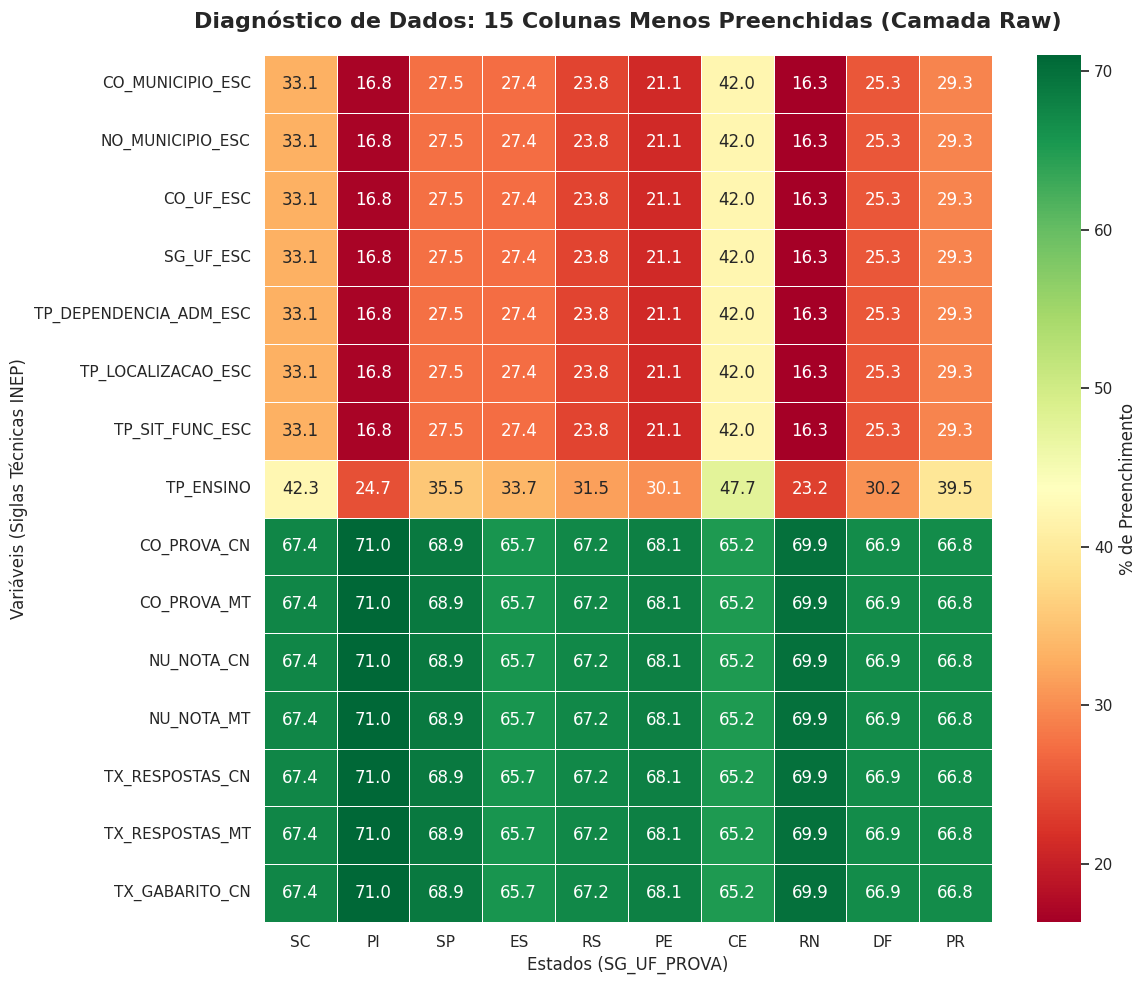

In [34]:
melhores_estados = [row['Estado'] for row in relatorio_estados.limit(10).collect()]
filtro_melhores_estados = leitura.filter(F.col("SG_UF_PROVA").isin(melhores_estados))

caminho_dicionario = 'data_raw/Dicionário_Microdados_Enem_2021.xlsx - MICRODADOS_ENEM_2021.csv'

coluna_dados = [c for c in leitura.columns if c != "SG_UF_PROVA"]
contagem_colunas = [F.count(c).alias(c) for c in coluna_dados]

analise_colunas = filtro_melhores_estados.groupBy("SG_UF_PROVA").agg(
    F.count('*').alias("Total_inscritos"),
    *contagem_colunas
)

colunas_pandas = analise_colunas.toPandas().set_index("SG_UF_PROVA")

for col in coluna_dados:
    colunas_pandas[col] = (colunas_pandas[col] / colunas_pandas["Total_inscritos"]) * 100

piores_colunas = colunas_pandas[coluna_dados].mean().nsmallest(15).index.tolist()

plot_piores_colunas = colunas_pandas[piores_colunas].T

plt.figure(figsize=(12, 10))
sns.set_theme(style="white")

ax = sns.heatmap(
    plot_piores_colunas, 
    annot=True, 
    fmt=".1f", 
    cmap="RdYlGn", 
    linewidths=.5,
    cbar_kws={'label': '% de Preenchimento'}
)

plt.title('Diagnóstico de Dados: 15 Colunas Menos Preenchidas (Camada Raw)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Estados (SG_UF_PROVA)', fontsize=12)
plt.ylabel('Variáveis (Siglas Técnicas INEP)', fontsize=12)

plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1947/454966173.py:17: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")


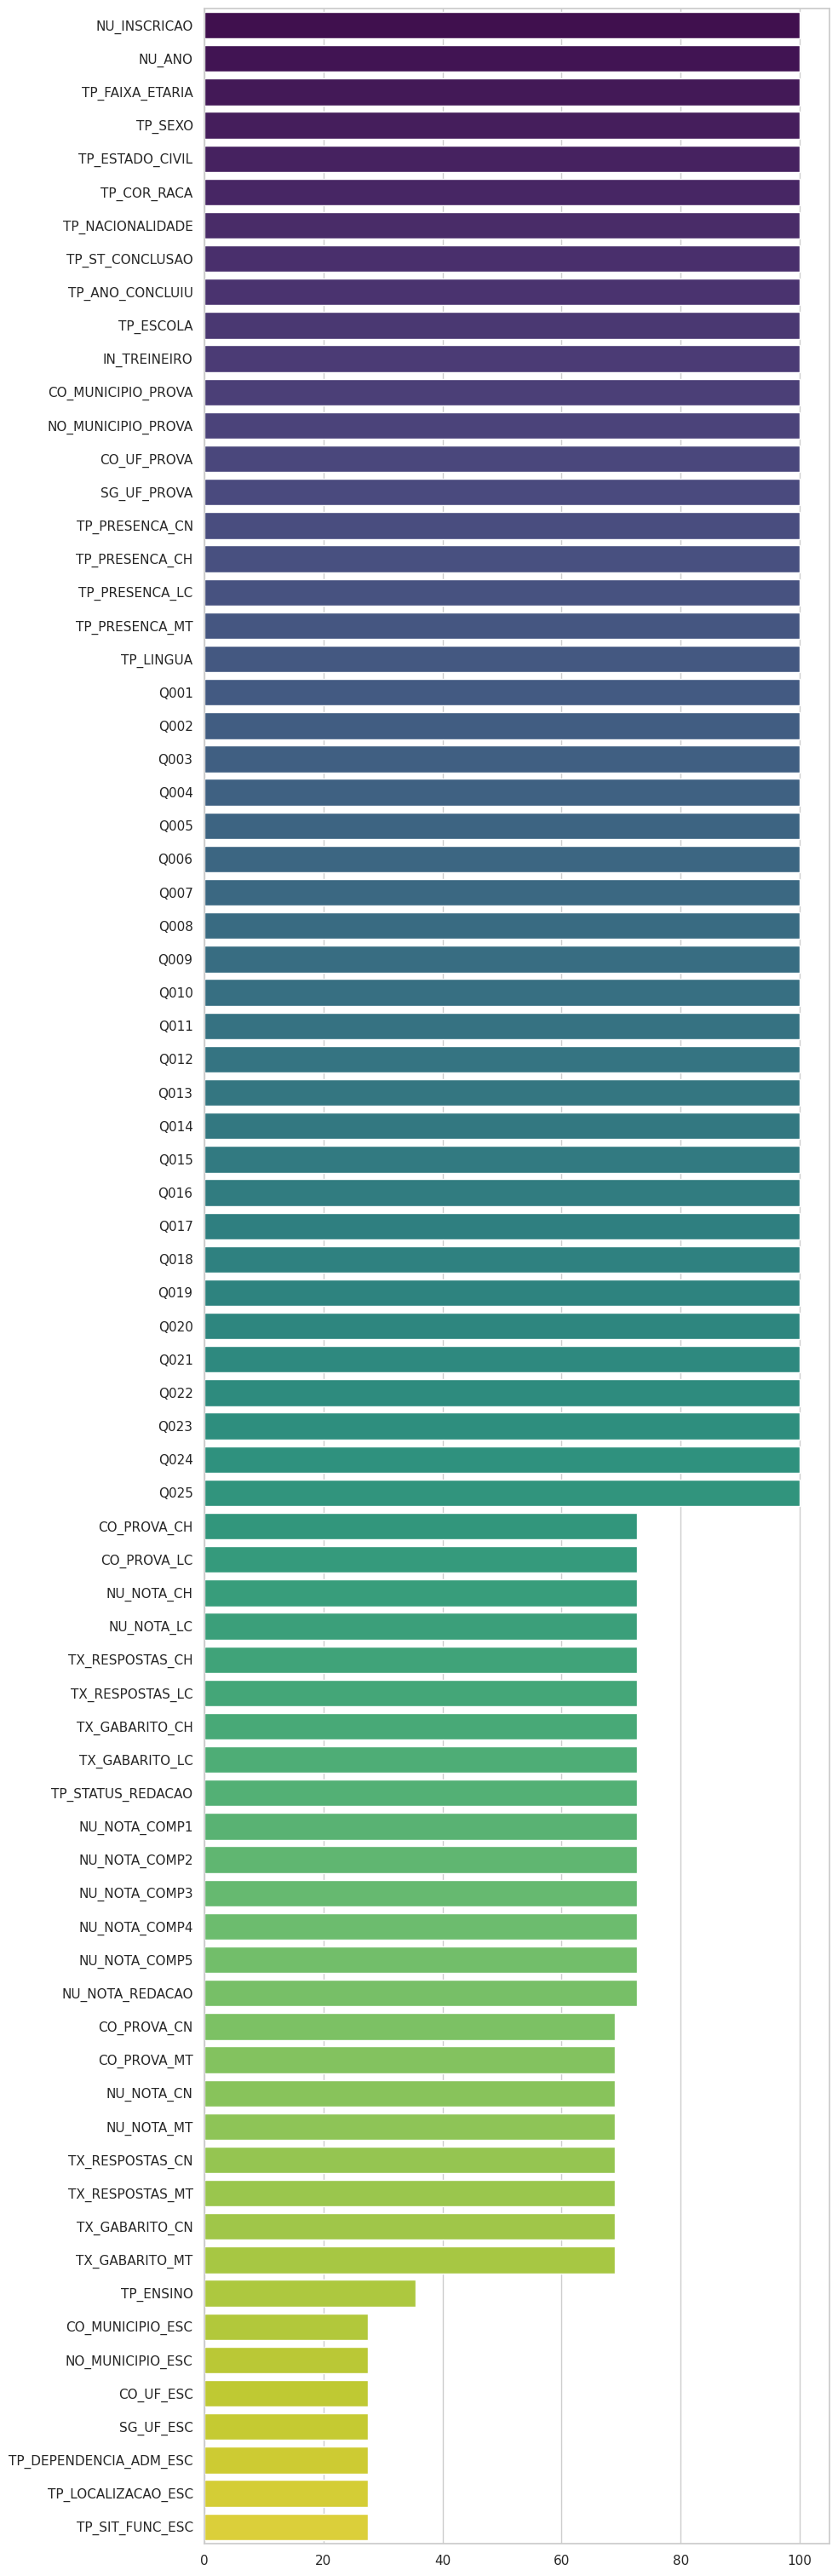

In [42]:
estado_SP = leitura.filter(F.col("SG_UF_PROVA") == "SP")

total_sp = estado_SP.count()

total_sp_nulos = estado_SP.agg(*[F.count(F.col(c)).alias(c) for c in estado_SP.columns]).collect()[0].asDict()

coluna_total_nulos = list(total_sp_nulos.keys())
percentual_coluna_nula = [(total_sp_nulos[c]/total_sp) * 100 for c in coluna_total_nulos]

dados_ordenados_completude = sorted(zip(coluna_total_nulos, percentual_coluna_nula), key=lambda x: x[1], reverse=True)

colunas_plot, valores_plot = zip(*dados_ordenados_completude)

plt.figure(figsize=(10, len(colunas_plot) * 0.4))
sns.set_theme(style="whitegrid")

sns.barplot(x=list(valores_plot), y=list(colunas_plot), palette="viridis")

plt.tight_layout()
plt.show()


Como mostrado na tabela acima, os estados: Santa Catarina, Ceará, São Paulo e Pará tem a porcentagem de colunas preenchidas maior que 83%, com isso em mente decidimos escolher o estado de São Paulo, visto que dentre esses tem mais que o dobro de linhas que os outros estados mostrando um espaço amostral muito maior e acomanhando a completude das colunas